# CAI4104 Final Project: Model Evaluation

In [1]:
import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import sklearn
import utils

# Let's check our software versions
print('------------')
print('### Python version: ' + __import__('sys').version)
print(f'### NumPy version: {np.__version__}')
print(f'### SciPy version: {sp.__version__}')
print(f'### Scikit-learn version: {sklearn.__version__}')
print(f'### Tensorflow version: {tf.__version__}')
print('------------')


2024-04-24 15:22:49.381985: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-24 15:22:49.384377: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-24 15:22:49.477148: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-24 15:22:49.861211: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-24 15:22:51.228437: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

------------
### Python version: 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:23:14) [GCC 10.4.0]
### NumPy version: 1.26.3
### SciPy version: 1.11.4
### Scikit-learn version: 1.3.0
### Tensorflow version: 2.16.1
------------


# Loading the models and model histories

In [2]:
predicted_path = '../predicted/'
histories_path = '../histories/'

test_t_dm_pred = np.load(predicted_path + 'test_t_dm_pred.npy')
test_t_nb_pred = np.load(predicted_path + 'test_t_nb_pred.npy')
test_t_lr_pred = np.load(predicted_path + 'test_t_lr_pred.npy')
#test_t_cnn_pred = np.load(predicted_path + 'test_t_cnn_pred.npy')

#cnn_hist = np.load(histories_path + 'cnn_hist.npy')

names = ['Dummy Classifier', 'Naive Bayes', 'Logistic Regression']
preds = [test_t_dm_pred, test_t_nb_pred, test_t_lr_pred]
#names = ['Dummy Classifier', 'Naive Bayes', 'Logistic Regression', 'CNN']
#preds = [test_t_dm_pred, test_t_nb_pred, test_t_lr_pred, test_t_cnn_pred]

# Loading the data

In [3]:
# Relative path to .npy files
data_path = '../data/'
data = np.load(data_path + 'data.npz')

# Load numpy arrays
train_x = data['train_x']
train_t = data['train_t']

val_x = data['val_x']
val_t = data['val_t']

test_x = data['test_x']
test_t = data['test_t']

assert train_x.shape[0] == train_t.shape[0], "Training image quantity mismatches label quantity"
assert val_x.shape[0] == val_t.shape[0], "Validation image quantity mismatches label quantity"
assert test_x.shape[0] == test_t.shape[0], "Test image quantity mismatches label quantity"

num_images = train_x.shape[0] + val_x.shape[0] + test_x.shape[0]
image_shape = train_x.shape[1:]

print(f'{num_images} images with shape {image_shape}')

35110 images with shape (48, 48, 1)


In [17]:
train_x_flat = train_x.reshape(train_x.shape[0], train_x.shape[1]*train_x.shape[2])
val_x_flat = val_x.reshape(val_x.shape[0], val_x.shape[1]*val_x.shape[2])
test_x_flat = test_x.reshape(test_x.shape[0], test_x.shape[1]*test_x.shape[2])

train_t_num = np.array([np.argmax(a) for a in train_t])
val_t_num = np.array([np.argmax(a) for a in val_t])
test_t_num = np.array([np.argmax(a) for a in test_t])

# Compute metrics for each model on test set
## Metrics:
####     - Accuracy
####     - F1 Score
####     - Precision
####     - Recall
####     - Area Under Curve (AUC), Receiver Operating Characteristic (ROC), done per class

In [40]:
from keras.metrics import Accuracy, F1Score, Precision, Recall
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def compute_metrics (name, test_t_pred):
    metrics = {}

    acc = Accuracy()
    acc.update_state(test_t_num, test_t_pred)
    metrics['accuracy'] = acc.result()

    #f1 = F1Score(average='micro')
    #f1.update_state(test_t_num, test_t_pred)
    #metrics['f1score_micro'] = f1.result()
    metrics['f1score_micro'] = -1

    prec = Precision()
    prec.update_state(test_t_num, test_t_pred)
    metrics['precision'] = prec.result()

    rec = Recall()
    rec.update_state(test_t_num, test_t_pred)
    metrics['recall'] = rec.result()

    print('{}:\n Accuracy: {:.2f}, F1-Score: {:.2f}, Precision: {:.2f}, Recall: {:.2f}'.format(
        name, metrics['accuracy'], metrics['f1score_micro'], metrics['precision'], metrics['recall']
    ))
    
    return metrics

def compute_roc (test_t_pred):
    fpr = {}
    tpr = {}
    roc = {}
    
    t_max = np.max(test_t_num)

    test_t_num_enc = label_binarize(test_t_num, classes=[0, 1, 2, 3, 4, 5, 6])
    test_t_pred_enc = label_binarize(test_t_pred, classes=[0, 1, 2, 3, 4, 5, 6])
    
    for i in range(t_max+1):
        fpr[i], tpr[i], _ = roc_curve(test_t_num_enc[:, i], test_t_pred_enc[:, i])
        roc[i] = auc(fpr[i], tpr[i])

    return fpr, tpr, roc

In [42]:
metrics = np.empty(len(names), dtype=object)
fprs = np.empty(len(names), dtype=object)
tprs = np.empty(len(names), dtype=object)
rocs = np.empty(len(names), dtype=object)  

for i in range(len(names)):
    metrics[i] = compute_metrics(names[i], preds[i])
    fprs[i], tprs[i], rocs[i] = compute_roc(preds[i])

Dummy Classifier:
 Accuracy: 0.25, F1-Score: -1.00, Precision: 0.86, Recall: 1.00
Naive Bayes:
 Accuracy: 0.21, F1-Score: -1.00, Precision: 0.86, Recall: 0.97
Logistic Regression:
 Accuracy: 0.35, F1-Score: -1.00, Precision: 0.87, Recall: 0.91


# Evaluate and create graphs for each model history and ROC

In [45]:
def evaluate_cnn_history (name, history, metrics):
    for metric in metrics.keys():
        plt.plot(history.history[metric])
        plt.plot(history.history['val_' + metric])
        plt.axhline(metrics[metric])
        plt.title('{} {}'.format(name, metric))
        plt.ylabel(metric)
        plt.xlabel('epoch')
        plt.legend(['train', 'val', 'test'], loc='upper left')
        plt.show()   

def evaluate_roc (name, fpr, tpr, roc):
    colors = ['red', 'green', 'purple', 'yellow', 'blue', 'orange']
    classes = ['angry', 'disgusted', 'fearful', 'happy', 'sad', 'surprised']
    
    for i, color in enumerate(colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC of class {} (area = {:.2f})'.format(classes[i], roc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.title('receiver operating characteristic on test set for each class of model {}'.format(name))
    plt.legend(loc='lower right')
    plt.show()

Dummy Classifier accuracy: 0.25
Naive Bayes accuracy: 0.21
Logistic Regression accuracy: 0.35

Dummy Classifier f1score_micro: -1.00
Naive Bayes f1score_micro: -1.00
Logistic Regression f1score_micro: -1.00

Dummy Classifier precision: 0.86
Naive Bayes precision: 0.86
Logistic Regression precision: 0.87

Dummy Classifier recall: 1.00
Naive Bayes recall: 0.97
Logistic Regression recall: 0.91



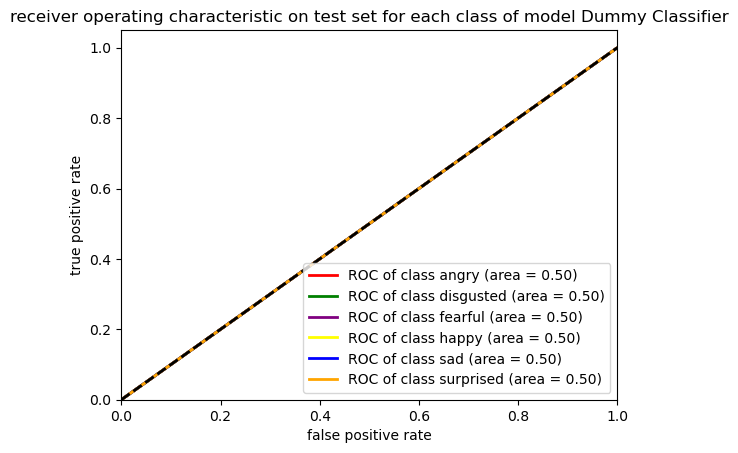

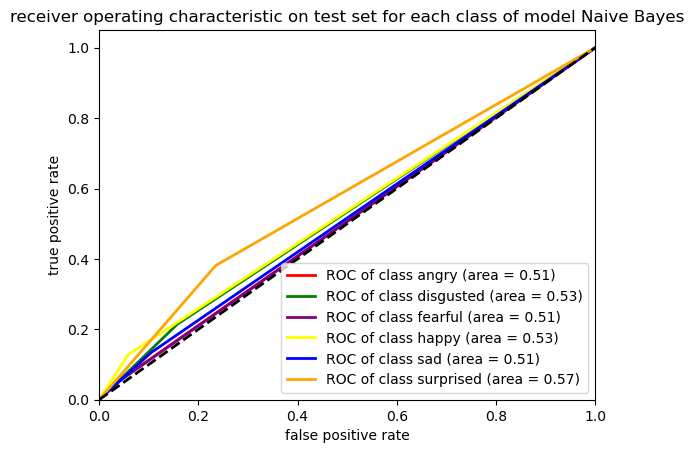

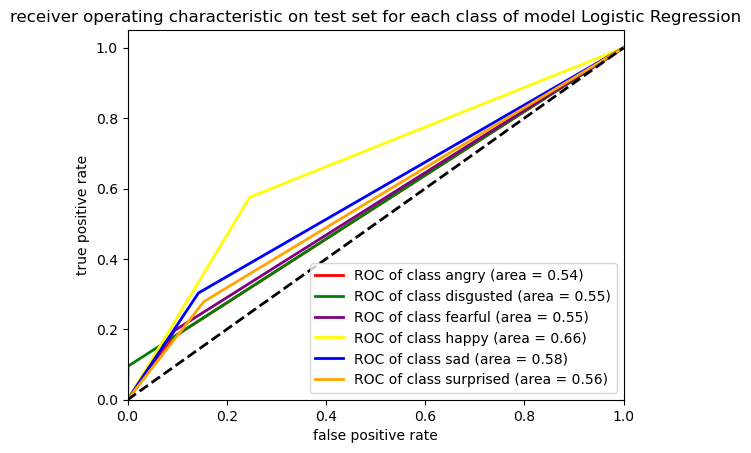

In [46]:
for metric in metrics[0].keys():
    for i in range(len(names)):
        print('{} {}: {:.2f}'.format(names[i], metric, metrics[i][metric]))
    print('')
        
#evaluate_cnn_history('CNN', cnn_hist, cnn_metrics)

for i, name in enumerate(names):
    evaluate_roc(name, fprs[i], tprs[i], rocs[i])